# 创建训练好的model
## 准备数据
## 训练模型

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 300)               235500    
                                                                 
 dense_7 (Dense)             (None, 100)               30100     
                                                                 
 dense_8 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4802 - accuracy: 0.8280 - val_loss: 0.3608 - val_accuracy: 0.8708
Epoch 2/100
1719/1719 [============

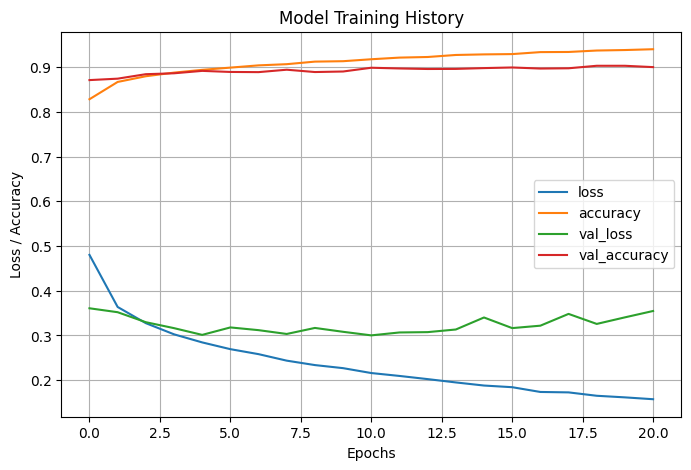


--- 评估测试集 ---
313/313 [==============================] - 0s 1ms/step - loss: 0.3461 - accuracy: 0.8878
Test Loss: 0.3461
Test Accuracy: 0.8878
1/1 [==============================] - 0s 45ms/step

--- 预测示例 ---
Predictions (Classes): [9 2 1]
Predictions (Names): ['Ankle boot' 'Pullover' 'Trouser']
Actual values (Classes): [9 2 1]
Actual values (Names): ['Ankle boot' 'Pullover' 'Trouser']


In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 设置随机种子
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 1. 加载和准备数据
# Keras 中内置了 Fashion MNIST 数据集
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# 验证 Fashion MNIST 数据（可选）
# print(f"X_train_full shape: {X_train_full.shape}") # (60000, 28, 28)
# print(f"y_train_full shape: {y_train_full.shape}") # (60000,)

# 2. 数据预处理和切分
# A) 创建验证集：从训练集中分离出前5000张图片作为验证集
# B) 数据归一化：将像素值从 0-255 缩放到 0-1 范围
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
# C) 归一化测试集
X_test = X_test / 255.0

# (可选) 定义类别名称，用于后续可视化
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# 3. 构建模型 (MLP)
model = keras.Sequential([
    # 关键：将 28x28 的 2D 图像展平为 1D 向量 (784个元素)
    # 这是 MLP (全连接层) 所需的输入格式
    keras.layers.Flatten(input_shape=[28, 28]),

    # 隐藏层 1：使用 300 个神经元 (图像分类通常比回归需要更多神经元)
    keras.layers.Dense(300, activation="relu"),

    # 隐藏层 2：使用 100 个神经元
    keras.layers.Dense(100, activation="relu"),

    # 输出层：
    # 1. 10个神经元 (对应 10 个类别)
    # 2. "softmax" 激活：确保所有输出概率相加为1，用于多类别分类
    keras.layers.Dense(10, activation="softmax")
])

# 4. 编译模型
model.compile(
    # 损失函数：
    # "sparse_categorical_crossentropy" 适用于标签是整数（如 0, 1, ..., 9）的多分类问题
    loss="sparse_categorical_crossentropy",

    # 优化器：继续使用 Adam
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),

    # 评估指标：
    # "accuracy" 是分类问题中最常用的指标
    metrics=["accuracy"]
)

model.summary()

# 5. 定义回调 (逻辑与之前完全相同)

# 优化：只保存在验证集上损失最低的模型
# 注意：我们监控 'val_loss' 或 'val_accuracy' 都可以。'val_loss' 通常更稳定
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_fashion_mnist_model.h5",
                                                monitor='val_loss',
                                                save_best_only=True)

# 优化：如果验证集损失在 10 个 epoch 内没有改善，则停止训练
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  monitor='val_loss',
                                                  restore_best_weights=True)

# 6. 训练模型
# 注意：epochs 设为 100，让 EarlyStopping 去决定何时停止
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

# 7. 评估和分析

# 绘制学习曲线
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1) # 移除 y 轴限制，因为 loss 可能会大于 1
plt.title("Model Training History")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy")
plt.show()

# 在测试集上评估最终模型
# (由于 restore_best_weights=True, model 已恢复到最佳状态)
print("\n--- 评估测试集 ---")
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


loaded_model = keras.models.load_model("my_fashion_mnist_model.h5")
X_new = X_test[:3]
y_proba = loaded_model.predict(X_new)
y_pred_classes = np.argmax(y_proba, axis=-1)

print("\n--- 预测示例 ---")
print("Predictions (Classes):", y_pred_classes)
print("Predictions (Names):", np.array(class_names)[y_pred_classes])
print("Actual values (Classes):", y_test[:3])
print("Actual values (Names):", np.array(class_names)[y_test[:3]])

# 基于训练好的model进行迁移学习

In [4]:
model_A = keras.models.load_model("my_fashion_mnist_model.h5")
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [5]:
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1]) # 保留所有层，除了输出层
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid")) # 添加新的输出层

In [11]:
# 由于最后一层权重是随机初始化的 直接开始反向传播会改变常用的那些层
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=1e-4,clipnorm=1.0)
model_B_on_A.compile(loss= "binary_crossentropy", optimizer= optimizer,metrics=["binary_crossentropy"])

In [12]:
history = model_B_on_A.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
1719/1719 [==============================] - 3s 2ms/step - loss: -509.1604 - binary_crossentropy: -509.1604 - val_loss: -515.3168 - val_binary_crossentropy: -515.3168
Epoch 2/100
1719/1719 [==============================] - 3s 2ms/step - loss: -516.9380 - binary_crossentropy: -516.9380 - val_loss: -523.1074 - val_binary_crossentropy: -523.1074
Epoch 3/100
1719/1719 [==============================] - 4s 2ms/step - loss: -524.6912 - binary_crossentropy: -524.6912 - val_loss: -530.8963 - val_binary_crossentropy: -530.8963
Epoch 4/100
1719/1719 [==============================] - 6s 3ms/step - loss: -532.4389 - binary_crossentropy: -532.4389 - val_loss: -538.6847 - val_binary_crossentropy: -538.6847
Epoch 5/100
 636/1719 [==========>...................] - ETA: 3s - loss: -537.9831 - binary_crossentropy: -537.9831

KeyboardInterrupt: 

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=1e-4,clipnorm=1.0)
model_B_on_A.compile(loss= "binary_crossentropy", optimizer= optimizer,metrics=["accuracy"])

history = model_B_on_A.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb])

In [ ]:
model_B_on_A.evaluate(X_test, y_test)